# Setup and Data Preparation

In [13]:
import os
import kagglehub

path = kagglehub.dataset_download("franciscogcc/financial-data")
financial_data_path = os.path.join(path, "financial_regression.csv")
print("Path to dataset file:", financial_data_path)

path = kagglehub.dataset_download("henryshan/tesla-stock-price")
tesla_data_path = os.path.join(path, "TSLA.csv")
print("Path to dataset file:", tesla_data_path)

Path to dataset file: /kaggle/input/financial-data/financial_regression.csv
Path to dataset file: /kaggle/input/tesla-stock-price/TSLA.csv


In [12]:
!ls /root/.cache/kagglehub/datasets/henryshan/tesla-stock-price/versions/2

TSLA.csv


In [26]:
import pandas as pd

# Load Tesla and Gold data
tesla_df = pd.read_csv(tesla_data_path, parse_dates=["Date"])
print(tesla_df.head())

gold_df = pd.read_csv(financial_data_path, parse_dates=["date"])
print(gold_df.head())

        Date      Open      High       Low     Close  Adj Close     Volume
0 2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
1 2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2 2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
3 2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
4 2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500
        date  sp500 open  sp500 high  sp500 low  sp500 close  sp500 volume  \
0 2010-01-14      114.49      115.14     114.42       114.93   115646960.0   
1 2010-01-15      114.73      114.84     113.20       113.64   212252769.0   
2 2010-01-18         NaN         NaN        NaN          NaN           NaN   
3 2010-01-19      113.62      115.13     113.59       115.06   138671890.0   
4 2010-01-20      114.28      114.45     112.98       113.89   216330645.0   

   sp500 high-low  nasdaq open  nasdaq high  nasdaq low  ...  palladium high  \
0

In [29]:
import pandas as pd

# Keep only required columns
gold_df = gold_df[['date', 'gold close']]
gold_df.columns = ['Date', 'Gold']
print(gold_df.head())

# What about the Nan values

# # Merge on Date
tesla_gold_df = pd.merge(tesla_df, gold_df, on='Date', how='inner')
tesla_gold_df.set_index('Date', inplace=True)

# # Optional: drop rows with missing values
# df.dropna(inplace=True)

print(tesla_gold_df.head())

                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

              Gold  
Date                
2010-06-29  121.27  
2010-06-30  121.68  
2010-07-01  117.04  
2010-07-02  118.49  
2010-07-06  116.51  


# Part 1: Prediction with LSTM

## LSTM with Tesla-only Data

In [30]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Choose input features and target
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
target_index = features.index('Adj Close')

df = tesla_df[features]

# Step 2: Normalize all features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Step 3: Create sequences
def create_sequences(data, look_back=60, target_index=4):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i, target_index])  # Predict 'Adj Close'
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, look_back=60, target_index=target_index)

# Step 4: Reshape
print(f"X shape: {X.shape}, y shape: {y.shape}")
# X shape: (samples, time_steps, features) => e.g., (1500, 60, 7)

# Step 5: Train/Test split
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X shape: (3323, 60, 6), y shape: (3323,)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 5.6362e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 7.5469e-06
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 5.9266e-06
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 4.8590e-06
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 4.9621e-06
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 4.7788e-06
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 4.3667e-06
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 5.2651e-06
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 4.3491e-06
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 4.7744e-06
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

Performance on test data:
  MSE : 922.3686
  MAE : 22.8066
  RMSE: 30.3705


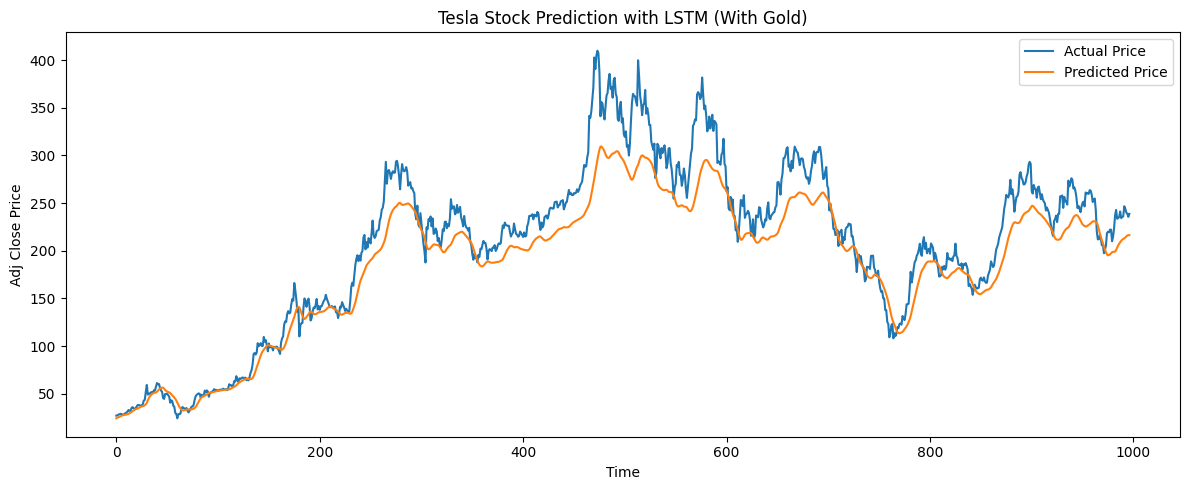

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 6: Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Step 7: Predict and inverse scale
pred = model.predict(X_test)

# Extract the 'Adj Close' column's scaler range for inverse transform
# We create a dummy array with same shape as input for inverse_transform
pad = np.zeros((len(pred), scaled.shape[1]))
pad[:, target_index] = pred.flatten()
predicted_prices = scaler.inverse_transform(pad)[:, target_index]

pad = np.zeros((len(y_test), scaled.shape[1]))
pad[:, target_index] = y_test.flatten()
actual_prices = scaler.inverse_transform(pad)[:, target_index]

# Step 8: Evaluate
mse_tesla = mean_squared_error(actual_prices, predicted_prices)
mae_tesla = mean_absolute_error(actual_prices, predicted_prices)
rmse_tesla = np.sqrt(mse_tesla)

print(f"\nPerformance results for Tesla-only:")
print(f"  MSE : {mse_tesla:.4f}")
print(f"  MAE : {mae_tesla:.4f}")
print(f"  RMSE: {rmse_tesla:.4f}")

# Step 9: Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("Tesla Stock Prediction with LSTM")
plt.xlabel("Time")
plt.ylabel("Adj Close Price")
plt.legend()
plt.tight_layout()
plt.show()

## LSTM with Tesla + Gold

In [37]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Choose input features and target
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Gold']
target_index = features.index('Adj Close')

df = tesla_gold_df[features]

# Step 2: Normalize all features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Step 3: Create sequences
def create_sequences(data, look_back=60, target_index=4):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i, target_index])  # Predict 'Adj Close'
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, look_back=60, target_index=target_index)

# Step 4: Reshape
print(f"X shape: {X.shape}, y shape: {y.shape}")
# X shape: (samples, time_steps, features) => e.g., (1500, 60, 7)

# Step 5: Train/Test split
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X shape: (3323, 60, 7), y shape: (3323,)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 6.2518e-04
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 1.0182e-05
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 5.3396e-06
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 5.1435e-06
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - loss: 4.8335e-06
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 5.0073e-06
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 4.6602e-06
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 4.8333e-06
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 5.0327e-06
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 4.2948e-06
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step

Performance on test data:
  MSE : 514.3283
  MAE : 16.1857
  RMSE: 22.6788


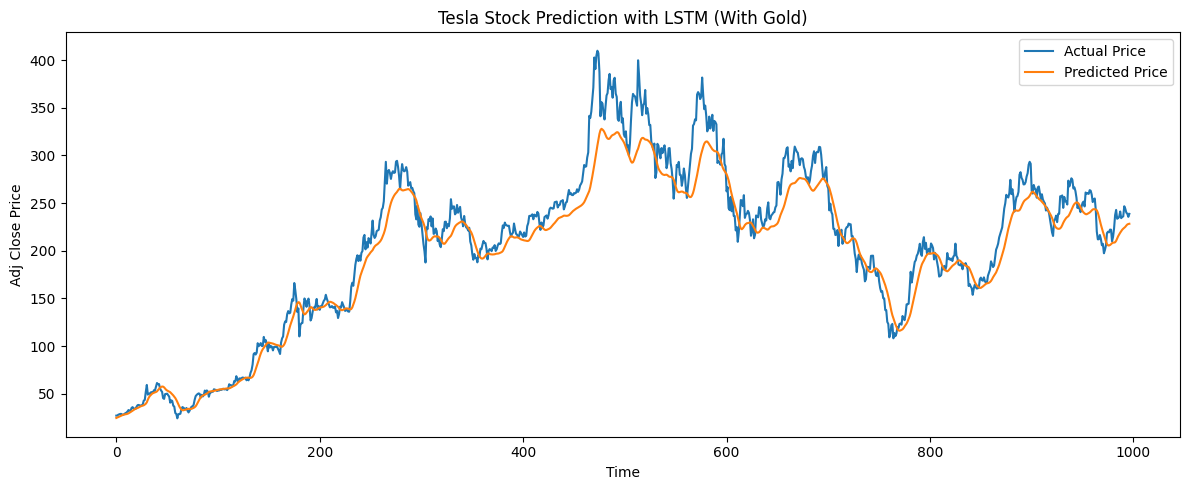

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Step 6: Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Step 7: Predict and inverse scale
pred = model.predict(X_test)

# Extract the 'Adj Close' column's scaler range for inverse transform
# We create a dummy array with same shape as input for inverse_transform
pad = np.zeros((len(pred), scaled.shape[1]))
pad[:, target_index] = pred.flatten()
predicted_prices = scaler.inverse_transform(pad)[:, target_index]

pad = np.zeros((len(y_test), scaled.shape[1]))
pad[:, target_index] = y_test.flatten()
actual_prices = scaler.inverse_transform(pad)[:, target_index]

# Step 8: Evaluate
mse_tesla_gold = mean_squared_error(actual_prices, predicted_prices)
mae_tesla_gold = mean_absolute_error(actual_prices, predicted_prices)
rmse_tesla_gold = np.sqrt(mse_tesla_gold)

print(f"\nPerformance on test data:")
print(f"  MSE : {mse_tesla_gold:.4f}")
print(f"  MAE : {mae_tesla_gold:.4f}")
print(f"  RMSE: {rmse_tesla_gold:.4f}")

# Step 9: Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("Tesla Stock Prediction with LSTM (With Gold)")
plt.xlabel("Time")
plt.ylabel("Adj Close Price")
plt.legend()
plt.tight_layout()
plt.show()

          Model         MSE        MAE       RMSE
0    Tesla-only  922.368577  22.806609  30.370522
1  Tesla + Gold  514.328257  16.185745  22.678806


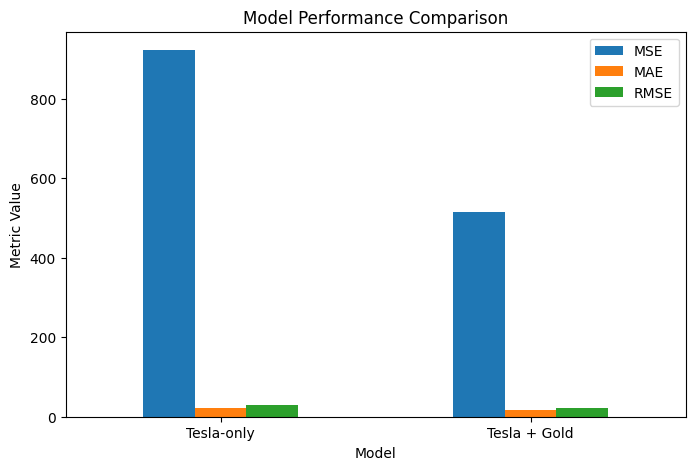

In [39]:
import pandas as pd

# Create a DataFrame to display the comparison
comparison_df = pd.DataFrame({
    'Model': ['Tesla-only', 'Tesla + Gold'],
    'MSE': [mse_tesla, mse_tesla_gold],
    'MAE': [mae_tesla, mae_tesla_gold],
    'RMSE': [rmse_tesla, rmse_tesla_gold]
})

print(comparison_df)

# Optional: Plot the performance comparison
comparison_df.set_index('Model')[['MSE', 'MAE', 'RMSE']].plot(kind='bar', figsize=(8, 5))
plt.title("Model Performance Comparison")
plt.ylabel("Metric Value")
plt.xlabel("Model")
plt.xticks(rotation=0)
plt.show()

# Part 2: Prediction with Transformers